# Kolla nya idéer och features 
### Speciellt för att prioritera mellan hästar i olika lopp
- kelly vs proba
- antal hästar i loppen som feature
- motståndarinfo
  - De tre bäst rankade motståndarna i loppet, deras antal streck
  - genomsnittet av någon ranking för hästarna
  - ...




## 1. En sorterad lista med proba och/eller kelly 
Från den listan plockas hästar tills max insats är nådd, kanske lltid spika en eller två hästar

In [ ]:
# moduler
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv
import flaml
import pickle
from IPython.display import display
# # read a model from a file with pickle
with open('..\\modeller\\FLAML_model.sav', 'rb') as f:
    model = pickle.load(f)
with open('..\\modeller\\FLAML2_model.sav', 'rb') as f:
    model2 = pickle.load(f)
    
pd.set_option('display.width', 100)


In [ ]:
def remove_features(df_, remove_mer=[]):
    df = df_.copy()
    df.drop([ 'startnr', 'avd','vodds', 'podds', 'bins', 'h1_dat',
              'h2_dat', 'h3_dat', 'h4_dat', 'h5_dat'], axis=1, inplace=True)
    if remove_mer:
            df.drop(remove_mer, axis=1, inplace=True)

    return df


def load_enc():
    with open('..\\modeller/encoder.sav', 'rb') as file:
        enc = pickle.load(file)
    return enc
def ordinal_enc(df_, feature):
    enc = load_enc()
    df = df_.copy()
    enc.transform(df[[feature]])
    # enc.fit_transform(df[[feature]])
    df[[feature]] = enc.transform(df[[feature]])
    return df

In [ ]:
# skapa data
df = pd.read_csv('..\\all_data.csv')
X=df.copy()
X.drop('plac', axis=1, inplace=True)
X = ordinal_enc(X, 'häst')
y=(df.plac==1)*1   # plac 1 eller 0


In [ ]:
# model1 är FLAML och model2 är FLAML2
proba = model.predict_proba(remove_features(X))
proba2 = model2.predict_proba(remove_features(X))
X['proba'] = proba[:,1]
X['proba2'] = proba2[:, 1]


In [ ]:
def kelly(proba, streck, odds):  # proba = prob winning, streck i % = streck
    if odds is None:
        o = 100/streck.copy()
    else:
        o=odds.copy()
            
    # for each values > 50 in odds set to 1
    o[o>40]=1
    return (o*proba - (1-proba))/o
            

Xtst = pd.read_csv('..\\sparad_scrape.csv')

#df['f'] = (df.proba*df.vodds - 1) / (df.vodds-1)  # kelly formel
Xtst['kellys'] = kelly(Xtst.proba, Xtst.streck+1, None)
proba2 = model2.predict_proba(remove_features(Xtst))
Xtst['proba2'] = proba2[:, 1]
Xtst['kelly2'] = kelly(Xtst.proba2, Xtst.streck+1, None)


In [ ]:
Xtst[['avd' , 'startnr', 'proba','kellys','proba2','kelly2']]

## plocka hästar efter proba och kelly till en df
1. Upp till 300:-
2. Minst en häst per avd
3. Lopp utan favoriter får utspridda låga värden och väljs inte för "helgardering" - hur lösa detta?
   

In [ ]:
def compute_total_insats(df):
    insats=0
    # group by avd
    summa = df.groupby('avd').avd.count().prod() / 2   
    return summa

def fill_up_dfSpel(df_, max_insats=300,metod='proba'):
    # dfSpel är de hästar som ska spela
    df=df_.copy()
    dfSpel = pd.DataFrame()
    df=df.sort_values(by=metod, ascending=[False])
    curr_insats = 0
    for index, row in df.iterrows():
        dfSpel = dfSpel.append(row)
        curr_insats = compute_total_insats(dfSpel)
        if curr_insats>max_insats+30:
            dfSpel = dfSpel.iloc[:-1,:]
            break
        # print(curr_insats)

    print(compute_total_insats(dfSpel))
    return dfSpel


## Lägg in antal hästar som feature

In [ ]:
def lägg_in_antal_hästar(df_):
    df = df_.copy()
    # count number per avdeling
    # df_count = df.groupby(['datum', 'avd'])['avd'].count()
    df['ant_per_lopp'] = None
    df['ant_per_lopp'] = df.groupby(['datum', 'avd'])['avd'].transform('count')

    # drop startnr because it has too many NaN
    # drop vodds, podds, bins because they are not known before v75
    X = df.drop(['plac', 'startnr', 'vodds', 'podds', 'bins',   # behåll avd som tas bort senare
                'h1_dat', 'h2_dat', 'h3_dat', 'h4_dat', 'h5_dat', ], axis=1)

    y = (df['plac'] == 1)*1

    return X, y
X,y = lägg_in_antal_hästar(df)

In [ ]:
X.columns

In [ ]:
# använda catboostClassifier
from catboost import CatBoostClassifier, Pool,cv


In [ ]:
# get numerical features and cat_features
num_features = list(X.drop('avd', axis=1).select_dtypes(include=[np.number]).columns)
cat_features = list(X.drop('avd', axis=1).select_dtypes(include=['object']).columns)
print(f'Rätt längd på summan (med datum)? {1+len(num_features)+len(cat_features)} == {len(X.columns)}')
# check cat_features isna
print('NaN before:', X[cat_features].isna().sum()[
      X[cat_features].isna().sum() > 0].sort_values(ascending=False).sum())

# impute 'missing' for all NaN in cat_features
X[cat_features] = X[cat_features].fillna('missing')
print('NaN after:', X[cat_features].isna().sum().sum())


In [ ]:
"""
cross validation with catboost
"""
def catboost_cv(X, y, cat_features, fold_count=5):

    # Create a pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    params = {"iterations": 1000,
              "loss_function": "Logloss",
              "verbose": False}

    cv_results = cv(pool, params, fold_count=fold_count,

                    early_stopping_rounds=100,
                    # loss_function='Logloss',
                    shuffle=False,
                    type='TimeSeries',
                    verbose=False)
    return cv_results


In [ ]:
result = catboost_cv(X.drop('avd', axis=1), y, cat_features)

In [ ]:
result['test-Logloss-mean'].min()


med  antal hästar som feature: 0.2396187999030749  
utan antal hästar som feature: 0.23964830518637106  
Minimalt bättre men det är inte vad jag vill uppnå utan bättre viktning mellan hästar i olika lopp

# Tester med olika lösningar 

In [196]:
# moduler
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv
from IPython.display import display
pd.set_option('display.width', 100)


In [197]:
# skapa data
df = pd.read_csv('..\\all_data.csv')
# Följande datum saknar avd==5 och kan inte användas
saknas = ['2015-08-15', '2016-08-13', '2017-08-12']
df = df[~df.datum.isin(saknas)]
X = df.copy()
X.drop('plac', axis=1, inplace=True)
# X = ordinal_enc(X, 'häst')
y = (df.plac == 1)*1   # plac 1 eller 0


def get_data_for_catboost(X):
    # get numerical features and cat_features
    num_features = list(X.drop('avd', axis=1).select_dtypes(
        include=[np.number]).columns)
    cat_features = list(X.drop('avd', axis=1).select_dtypes(
        include=['object']).columns)
    print(f'Rätt längd på summan (med datum)? {1+len(num_features)+len(cat_features)} == {len(X.columns)}')
    # check cat_features isna
    print('NaN before:', X[cat_features].isna().sum()[X[cat_features].isna().sum() > 0].sort_values(ascending=False).sum())

    # impute 'missing' for all NaN in cat_features
    X[cat_features] = X[cat_features].fillna('missing')
    print('NaN after:', X[cat_features].isna().sum().sum())
    return X, cat_features

X, cat_features = get_data_for_catboost(X)
# cat_features = list(X.drop('avd', axis=1).select_dtypes(include=['object']).columns)
print('cat_features:',cat_features)

# antal hästar per avdeling
def lägg_in_antal_hästar(df_):
    df = df_.copy()
    df['ant_per_lopp'] = None
    df['ant_per_lopp'] = df.groupby(['datum', 'avd'])['avd'].transform('count')
    return df

# mest streck per avdeling
def mest_streck(X_, i, datum, avd):
    X = X_.copy()
    X.sort_values(by=['datum', 'avd', 'streck'], ascending=[
                  True, True, False], inplace=True)
    return X.loc[(X.datum == datum) & (X.avd == avd), 'streck'].iloc[i]

# mest streck per avd som fetures (n bästa)
def lägg_in_motståndare(X_, ant_motståndare):
    X = X_.copy()

    # set X['motståndare1'] to largest streck in every avd
    grouped = X.groupby(['datum', 'avd'])['streck']
    X['motståndare1'] = grouped.transform(max)

    for i in range(2, ant_motståndare+1):
        # set X['motståndare'+str(i)] to ith largest streck in every avd
        X['motståndare' + str(i)] = grouped.transform(lambda x: x.nlargest(i).min())

    return X

# diff streck per avd som fetures (n största diffarna)
def lägg_in_diff_motståndare(X_, motståndare):
    X = X_.copy()

    # set X['motståndare1'] to largest streck in every avd
    grouped = X.groupby(['datum', 'avd'])['streck']
    X['diff1'] = grouped.transform(max) - X.streck

    for i in range(2, motståndare+1):
        # set X['motståndare'+str(i)] to ith largest streck in every avd
        X['diff' + str(i)] = grouped.transform(lambda x: x.nlargest(i).min()) - X.streck

    return X

# Skapa X_train och X_test
def create_X_train_test(X, y, datum):
    X_train = X[X.datum < datum]
    X_test = X[X.datum == datum]
    y_train = y[X.datum < datum]
    y_test = y[X.datum == datum]
    return X_train, X_test, y_train, y_test

#make häst, bana, kusk lower case

for f in ['häst', 'bana', 'kusk', 'h1_kusk', 'h2_kusk', 'h3_kusk', 'h4_kusk', 'h5_kusk', 'h1_bana', 'h2_bana', 'h3_bana', 'h4_bana', 'h5_bana']:
    # print(X[f], type(X[f]))
    X[f] = X[f].str.lower()


Rätt längd på summan (med datum)? 78 == 78
NaN before: 369
NaN after: 0
cat_features: ['datum', 'bana', 'häst', 'kusk', 'kön', 'h1_dat', 'h1_kusk', 'h1_bana', 'h2_dat', 'h2_kusk', 'h2_bana', 'h3_dat', 'h3_kusk', 'h3_bana', 'h4_dat', 'h4_kusk', 'h4_bana', 'h5_dat', 'h5_kusk', 'h5_bana']


In [198]:
def kelly(proba, streck, odds):  # proba = prob winning, streck i % = streck
    if odds is None:
        o = 100/streck.copy()
    else:
        o = odds.copy()

    # for each values > 50 in odds set to 1
    o[o > 40] = 1
    return (o*proba - (1-proba))/o

In [199]:
# pick the häst to play
def compute_total_insats(df):
    insats = 0
    # group by avd
    summa = df.groupby('avd').avd.count().prod() / 2
    return summa

# för en omgång (ett datum) ta ut största diff för streck per avd men bara om diff >= 25
def största_diff_per_avd(df_, ant,only_clear):
    df=df_.copy()
    min_diff = 25 if only_clear else 0
    # sortera på avd,streck
    df = df.sort_values(['avd','streck'], ascending=[False, False])
    diff_list = []
    for avd in range(1,8):
        diff = df.loc[df.avd==avd].streck.iloc[0] - df.loc[df.avd==avd].streck.iloc[1]
        if diff >= min_diff:
            diff_list.append((avd,diff))

     # sortera på diff
    diff_list = sorted(diff_list, key=lambda x: x[1], reverse=True)   
    return diff_list[:ant]

# temp is a list of tuples (avd, diff). check if avd is in the list
def check_avd(avd, temp):
    for t in temp:
        if t[0] == avd:
            return True
    return False   


In [200]:
  
def spela(df_, max_insats=300, proba=True, kelly=True,ant_favoriter=0,streck=True,only_clear=False):
    df = df_.copy()
    # print('omg df',df.shape)
    dfSpel = pd.DataFrame()
    if proba:
        df = df.sort_values(by='proba', ascending=False)
        if kelly:
            df2 = df.sort_values(by='kelly', ascending=False)
    else:
        df = df.sort_values(by='kelly', ascending=False) # must be kelly
        
    # se till att vi har för alla avd. Välj den bästa per avd
    if proba:
        temp = df.sort_values(by=['proba'], ascending=False)
    else:
        temp = df.sort_values(by=['kelly'], ascending=False)    
    for avd in range(1, 8):
        dfSpel = dfSpel.append(temp[temp.avd == avd].iloc[0])
    #
    favorit_list = största_diff_per_avd(df, ant_favoriter,only_clear)
    curr_insats = 0
    cnt=0
    for index, row in df.iterrows():
        if check_avd(row.avd, favorit_list): # Inga fler hästar för avd med en favorit
            continue
        
        dfSpel = dfSpel.append(row)
        # print(dfSpel.shape)
        # print('row',row.shape)
        curr_insats = compute_total_insats(dfSpel)
        if curr_insats > max_insats+30:
            dfSpel = dfSpel.iloc[:-1, :]
            break
        if kelly & proba:
            row2 = df2.iloc[cnt]
            # print('row2',row2.shape)
            dfSpel = dfSpel.append(row2)
            # remove duplicates in dfSpel nd keep the first
        dfSpel = dfSpel.drop_duplicates(subset=['avd', 'häst'], keep='first')
        # print('dfSpel',dfSpel.shape)    
        curr_insats = compute_total_insats(dfSpel)
        if curr_insats > max_insats+30:
            dfSpel = dfSpel.iloc[:-1, :]
            break
        cnt +=1
                
    return dfSpel

# train with curr_datum
def learn(X_train, y_train, X_test, y_test, cat_features):
    train_pool = Pool(X_train.drop('avd', axis=1), label=y_train, cat_features=cat_features)
    test_pool = Pool(X_test.drop('avd', axis=1), label=y_test, cat_features=cat_features)
    cbc = CatBoostClassifier(iterations=1000, loss_function='Logloss', eval_metric='AUC', verbose=False)
    cbc.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100,use_best_model=True, verbose=False)
    return cbc

def beräkna_utdelning(dfSpel,ant_rätt, df_utdelning):
    if ant_rätt==7:
        slista = list(dfSpel.groupby('avd').avd.count()-1)
        sjuor = 1
        sexor = sum(slista)
        femmor =0
        for avd_ix in range(0, 7):
            for avd2_ix in range(avd_ix+1, 7):
                femmor += slista[avd_ix] * slista[avd2_ix]
    
    elif ant_rätt==6:
        sjuor=0
        avd_list = list(dfSpel.loc[dfSpel.rätt == 'OK']['avd'])  # avd med rätt
        missing = [x for x in range(1, 8) if x not in avd_list]
        sexor = dfSpel.loc[dfSpel.avd == missing[0], 'avd'].count()
        femmor=0
        for avd in avd_list:
            femmor+=dfSpel.loc[dfSpel.avd==avd, 'avd'].count()
        femmor=(femmor-6) * sexor
        
    elif ant_rätt==5:
        sjuor,sexor=0,0
        avd_list = list(dfSpel.loc[dfSpel.rätt == 'OK']['avd'])  # avd med rätt
        missing = [x for x in range(1, 8) if x not in avd_list]
        femmor=dfSpel.loc[dfSpel.avd==missing[0], 'avd'].count() + dfSpel.loc[dfSpel.avd==missing[1], 'avd'].count()
    else:
        sjuor,sexor,femmor = 0,0,0 
           
    datum = dfSpel.iloc[0].datum       
    priser = list(df_utdelning.loc[df_utdelning.datum ==datum, ['7rätt', '6rätt', '5rätt']].values[0])
    return sjuor,sexor,femmor, priser[0]*sjuor+ priser[1]*sexor + priser[2]*femmor

def rätta(y_validate, dfSpel, df_utdelning):
    yindex = y_validate.loc[y == 1].index
    # print(1,_,dfSpel.shape)
    ant_rätt = len(dfSpel.loc[dfSpel.index.isin(yindex)])
    # print(f': total insats {compute_total_insats(dfSpel)} med {dfSpel.shape[0]} spelade hästar: {ant_rätt} rätt')
    dfSpel['rätt'] = ' '
    dfSpel[['avd', 'streck','rätt']]
    dfSpel.loc[dfSpel.index.isin(yindex), 'rätt'] = 'OK'
    # print(2,_,dfSpel.shape)
    return  beräkna_utdelning(dfSpel, ant_rätt, df_utdelning)


## Loop över datum, learn+predict

In [201]:

def testa_flera_omg(X_,y_,typ, max_cnt=60): 
    X = X_.copy()
    y = y_.copy()

    # skriv ut parametrar som styr vilken lösning som testas
    max_insats = stats_typer.loc[stats_typer.typ == typ].insats.values[0]
    print('max_insats',max_insats)
    bProba = stats_typer.loc[stats_typer.typ == typ].proba.values[0]
    print('Proba',bProba)
    bKelly = stats_typer.loc[stats_typer.typ == typ].kelly.values[0]
    print('Kelly',bKelly)
    bAnt_hästar = stats_typer.loc[stats_typer.typ == typ].ant_hästar.values[0]
    ant_favoriter = stats_typer.loc[stats_typer.typ == typ].favoriter.values[0]
    only_clear = stats_typer.loc[stats_typer.typ == typ].only_clear.values[0]
    print('ant_favoriter',ant_favoriter, 'only_clear =',only_clear)
    motståndare = stats_typer.loc[stats_typer.typ == typ].motst_info.values[0]
    diff = stats_typer.loc[stats_typer.typ == typ].motst_diff.values[0]
    streck = stats_typer.loc[stats_typer.typ == typ].streck.values[0]
    
    if diff:
        print('Diff motståndare',motståndare)
    else:
        print(motståndare, ' motståndare')
        
    if bAnt_hästar:
        X = lägg_in_antal_hästar(X)
        print('lägg_in_antal_hästar per avd')
     
    if not streck:
        print('not streck')
          
    df_utdelning = pd.read_csv('..\\utdelning.csv')
    datum = df.datum.unique()
    spel_dict = {'typ':[],'datum':[],'insats':[], 'utdelning':[], 'sjuor':[], 'sexor':[], 'femmor':[]}
    kassa=0
    # ix = len(datum)//2+100   Detta ger mitten plus 100
    ix = 71  # Startar från '2015-12-29
    if motståndare>0:
        if diff:
            X=lägg_in_diff_motståndare(X, motståndare)
        else:    
            X=lägg_in_motståndare(X, motståndare)
        # print(X)
        
    for cnt,curr_datum in enumerate(datum[ix:-1]):
        # select data
        X_train = X.loc[df.datum<curr_datum].copy()
        y_train = y.loc[df.datum<curr_datum].copy()
        X_test = X.loc[df.datum>curr_datum].copy()
        y_test = y.loc[df.datum>curr_datum].copy()
        X_validate = X.loc[df.datum==curr_datum].copy()
        y_validate = y.loc[df.datum==curr_datum].copy()
        if not streck:
            X_train.drop('streck', axis=1, inplace=True)
            X_test.drop('streck', axis=1, inplace=True)
            # keep in X_validate for kelly formula
        
        # Learn
        cbc = learn(X_train, y_train, X_test, y_test, cat_features)
        
        # predict
        if not streck:
            validate_pool = Pool(X_validate.drop(['avd', 'streck'], axis=1),label=y_validate, cat_features=cat_features)
        else:
            validate_pool = Pool(X_validate.drop(['avd'], axis=1), label=y_validate, cat_features=cat_features)
        
        X_validate['proba'] = cbc.predict_proba(validate_pool)[:, 1]
        X_validate['kelly'] = kelly(X_validate.proba, X_validate.streck+1, None)
        
        # Spela
        dfSpel = spela(X_validate, max_insats=max_insats, proba=bProba, kelly=bKelly, 
                       ant_favoriter=ant_favoriter,streck=streck,only_clear=only_clear)
        
        # Rätta
        sjuor, sexor, femmor, utdelning = rätta(y_validate, dfSpel, df_utdelning)
        insats = compute_total_insats(dfSpel) 
        ant_spelade = dfSpel.shape[0]
        kassa += utdelning-insats
        print(f'{curr_datum} - insats: {insats}, ant spel: {ant_spelade}, rätt=({sjuor},{sexor},{femmor}), Utd: {utdelning}  :\tkassa: {kassa}')
        # append insats, utdelning, sjuor to spel_dict['datum']
        spel_dict['typ'].append(typ)
        spel_dict['datum'].append(curr_datum)
        spel_dict['insats'].append(insats)
        spel_dict['utdelning'].append(utdelning)
        spel_dict['sjuor'].append(sjuor)
        spel_dict['sexor'].append(sexor)
        spel_dict['femmor'].append(femmor)
        
        if cnt+1>=max_cnt:
            break


    print('Finished')
    return spel_dict,dfSpel


stats_typer = pd.DataFrame(columns=['typ', 'ant_datum', 'insats', 'ant_hästar',
                           'proba', 'kelly', 'motst_diff', 'motst_info', 'favoriter','only_clear', 'streck'])
stats_typer.loc[len(stats_typer)] =  ['1',  200, 300, True,  True,  True, False, 0, 0, False, True]
stats_typer.loc[len(stats_typer)] =  ['2',  200, 300, True,  True, False, False, 0, 0, False, True]
stats_typer.loc[len(stats_typer)] =  ['3',  200, 300, True, False,  True, False, 0, 0, False, True]
stats_typer.loc[len(stats_typer)] =  ['4',  200, 300, False, True,  True, False, 0, 0, False, True]
stats_typer.loc[len(stats_typer)] =  ['5',  200, 300, False, True, False, False, 0, 0, False, True]
stats_typer.loc[len(stats_typer)] =  ['6',  200, 300, False,False,  True, False, 0, 0, False, True]
stats_typer.loc[len(stats_typer)] =  ['7',  200, 3000, True, True,  True, False, 0, 0, False, True]
stats_typer.loc[len(stats_typer)] =  ['8',  200, 300, True,  True,  True, False, 0, 2, False, True]
stats_typer.loc[len(stats_typer)] =  ['9',  200, 300, True,  True,  True, False, 3, 0, False, True]
stats_typer.loc[len(stats_typer)] =  ['10', 200, 300, True,  True,  True, False, 3, 2, False, True]
stats_typer.loc[len(stats_typer)]  = ['11', 200, 300, True,  True,  True, False, 1, 2, False, True]
stats_typer.loc[len(stats_typer)]  = ['12', 200, 300, True,  True,  True, False, 1, 1, False, True]
stats_typer.loc[len(stats_typer)]  = ['13', 200, 300, True,  True,  True, False, 2, 2, False, True]
stats_typer.loc[len(stats_typer)]  = ['14', 200, 300, True,  True,  True, True,  2, 2, False, True]
stats_typer.loc[len(stats_typer)]  = ['15', 200, 300, True,  True,  True, True,  3, 2, False, True]
stats_typer.loc[len(stats_typer)]  = ['16', 200, 300, True,  True,  True, False, 2, 2,  True, True]
stats_typer.loc[len(stats_typer)]  = ['17', 200, 300, True,  True,  True, True,  2, 2,  True, True]
stats_typer.loc[len(stats_typer)]  = ['18', 200, 300, True,  True,  True, True,  3, 2,  True, True]
stats_typer.loc[len(stats_typer)]  = ['19', 200, 300, True,  True,  True, False, 0, 0, False, False]
stats_typer.loc[len(stats_typer)]  = ['20', 200, 300, True,  True,  True, True,  2, 2,  True, False]
stats_typer.loc[len(stats_typer)] =  ['21', 200, 300, False, True, False, True,  2, 2,  True, False]
stats_typer

### Kör tidigare datum
### Använd diff till motståndare
### Plocka endast favoriter som är solklara
### Hantera avd utan favoriter med många jämna


,typ,ant_datum,insats,ant_hästar,proba,kelly,motst_diff,motst_info,favoriter,only_clear,streck
0,1,200,300,True,True,True,False,0,0,False,True
1,2,200,300,True,True,False,False,0,0,False,True
2,3,200,300,True,False,True,False,0,0,False,True
3,4,200,300,False,True,True,False,0,0,False,True
4,5,200,300,False,True,False,False,0,0,False,True
5,6,200,300,False,False,True,False,0,0,False,True
6,7,200,3000,True,True,True,False,0,0,False,True
7,8,200,300,True,True,True,False,0,2,False,True
8,9,200,300,True,True,True,False,3,0,False,True
9,10,200,300,True,True,True,False,3,2,False,True


## Kör tester

In [202]:
def run_one_typ(typ):
    spel_dict, dfSpel = testa_flera_omg(X,y, typ, 1000)
    temp_stats = pd.DataFrame(spel_dict)
    temp_stats.typ=temp_stats.typ.astype('string') 
    return spel_dict, temp_stats, dfSpel

In [203]:
def uppdatera_spel_stats(temp_stats):
    spel_stats = pd.read_csv('spel_stats.csv')
    spel_stats = pd.concat([spel_stats, temp_stats], ignore_index=True)
    spel_stats.typ = spel_stats.typ.astype('string')
    spel_stats.drop_duplicates(subset=['typ', 'datum'], keep='last', inplace=True)
    spel_stats.to_csv('spel_stats.csv', index=False)
    return spel_stats

def bästa_kassa(stats):
    typlista = []
    for typ in stats.typ.unique():
        row = stats.loc[stats.typ == typ]
        kassa = row.utdelning.sum()-row.insats.sum()
        typlista.append((typ, kassa))
        
    typlista.sort(key=lambda x: x[1], reverse=True)
    print(typlista)

In [204]:
# Kör hela skiten
for typ in stats_typer.typ.unique()[3
                                    :]:
    print('Running typ: ', typ)
    spel_dict, temp_stats, dfSpel = run_one_typ(typ)
    spel_stats = uppdatera_spel_stats( temp_stats)
    bästa_kassa(spel_stats)



Running typ:  4
max_insats 300
Proba True
Kelly True
ant_favoriter 0 only_clear = False
0  motståndare


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

2016-01-02 - insats: 324.0, ant spel: 18, rätt=(0,2,20), Utd: 990  :	kassa: 666.0
2016-01-09 - insats: 240.0, ant spel: 18, rätt=(0,0,0), Utd: 0  :	kassa: 426.0
2016-01-16 - insats: 324.0, ant spel: 18, rätt=(0,0,5), Utd: 195  :	kassa: 297.0
2016-01-23 - insats: 180.0, ant spel: 19, rätt=(0,0,0), Utd: 0  :	kassa: 117.0
2016-01-30 - insats: 324.0, ant spel: 19, rätt=(0,0,0), Utd: 0  :	kassa: -207.0
2016-01-31 - insats: 288.0, ant spel: 18, rätt=(0,0,4), Utd: 0  :	kassa: -495.0
2016-02-06 - insats: 288.0, ant spel: 19, rätt=(0,0,0), Utd: 0  :	kassa: -783.0
2016-02-13 - insats: 324.0, ant spel: 19, rätt=(0,0,0), Utd: 0  :	kassa: -1107.0
2016-02-20 - insats: 324.0, ant spel: 19, rätt=(0,0,4), Utd: 0  :	kassa: -1431.0
2016-02-27 - insats: 288.0, ant spel: 18, rätt=(0,0,0), Utd: 0  :	kassa: -1719.0
2016-02-28 - insats: 324.0, ant spel: 18, rätt=(0,0,0), Utd: 0  :	kassa: -2043.0
2016-03-05 - insats: 256.0, ant spel: 18, rätt=(0,0,4), Utd: 80  :	kassa: -2219.0
2016-03-12 - insats: 288.0, ant s

### Här jämför jag spel_stats1 med spel_stats
Är de ungefär samma så kan man nog lita på ordningen mellan olika typ

In [205]:
bästa_kassa(spel_stats)
spel_stats1 = pd.read_csv('spel_stats1.csv')
bästa_kassa(spel_stats1)    

[('21', 91918.0), ('17', 66632.0), ('14', 53752.5), ('6', 51808.5), ('2', 43454.0), ('16', 41659.0), ('4', 18652.0), ('13', 17140.0), ('9', 9339.0), ('8', 122.0), ('5', -372.0), ('10', -4285.0), ('1', -15707.0), ('15', -20977.0), ('12', -21219.5), ('18', -22053.0), ('11', -33410.0), ('20', -39496.0), ('3', -48084.5), ('19', -50262.0), ('7', -250518.0)]
[]


In [312]:
### compute kassa
spel_stats.sort_values(by=['typ', 'datum'], inplace=True)
# set kassa to running sum of utdelning-insats
spel_stats.kassa = spel_stats.utdelning-spel_stats.insats
for x in spel_stats.typ.unique():
    spel_stats.loc[spel_stats.typ==x,'kassa'] = spel_stats[spel_stats.typ==x].kassa.cumsum()
    # spel_stats[spel_stats.typ==x].head(10)
spel_stats.to_csv('spel_stats.csv', index=False)

<AxesSubplot:xlabel='datum', ylabel='kassa'>

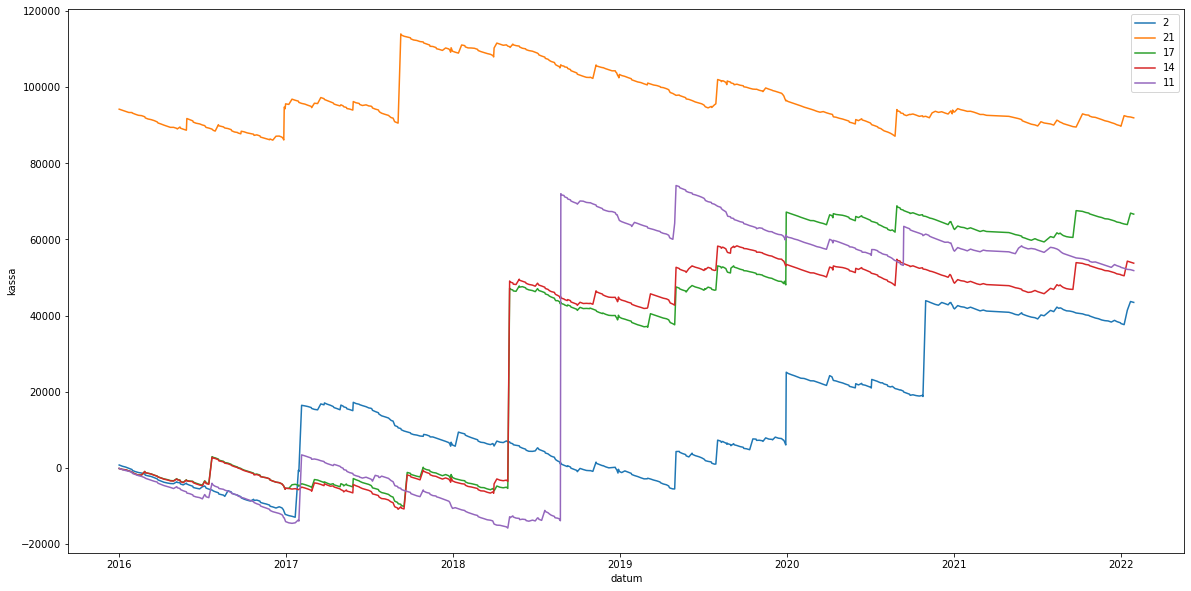

In [327]:
# plot spel_stats kassa over time
spel_stats = pd.read_csv('spel_stats.csv')
import matplotlib.pyplot as plt
import seaborn as sns

spel_stats.datum=pd.to_datetime(spel_stats.datum)
spel_stats.sort_values(by='datum', inplace=True)
spel_stats['year'] = spel_stats.datum.dt.year

fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='datum', y='kassa', data=spel_stats[spel_stats.typ == 2], label='2')
sns.lineplot(x='datum', y='kassa',  data=spel_stats[spel_stats.typ == 21], label='21')
sns.lineplot(x='datum', y='kassa', data=spel_stats[spel_stats.typ == 17],label='17')
sns.lineplot(x='datum', y='kassa', data=spel_stats[spel_stats.typ == 14],label='14')
sns.lineplot(x='datum', y='kassa', data=spel_stats[spel_stats.typ == 6],label='11')


In [294]:
spel_stats.loc[spel_stats.datum != '2016-01-16'].kassa.max()


113962.0

In [ ]:
def stats_for_typ(typ,stats):
    stats_row = stats.loc[stats.typ == typ]
    print(stats_row[['insats','utdelning','sjuor','sexor','femmor']].sum())
    print(f'Kassa (typ={typ}):',stats_row.utdelning.sum()-stats_row.insats.sum())
stats_for_typ(2,spel_stats)    
spel_stats.info()

In [325]:
# spel_stats['kassa'] = spel_stats.utdelning-spel_stats.insats
spel_stats.groupby('typ')[['sjuor','sexor','femmor','insats','kassa']].sum().sort_values(by='sjuor', ascending=False)
# spel_stats.loc[(spel_stats.typ == 6) & (spel_stats.year==2018)].tail(60)

,sjuor,sexor,femmor,insats,kassa
typ,,,,,
7,52,1290,13410,1193080.0,-70225482.0
2,34,584,4331,135928.0,5262898.0
21,31,601,4841,132566.0,44888659.0
17,28,515,4044,132408.0,14586674.0
14,28,516,4057,132235.5,13254573.0
10,28,524,4099,132563.0,-226556.0
11,26,482,3828,134306.0,-7645471.0
5,26,511,4006,134109.0,-2053731.0
8,24,437,3526,133837.0,-131719.0


In [208]:
for typ in stats_typer.typ.unique():
    # print(spel_stats.loc[spel_stats.typ == typ][['typ','kassa']])
    stats_typer.loc[stats_typer.typ == typ,'kassa'] = spel_stats[spel_stats.typ==typ].kassa.max()
stats_typer.kassa = stats_typer.kassa.astype('int')

stats_typer.sort_values(by='kassa', ascending=False)
stats_typer.groupby('only_clear')[['kassa']].mean()

,kassa
only_clear,
False,32410.0625
True,48129.0000
